In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# --- 1. Persiapan Data ---
# Harap unduh dan ekstrak dataset "Dry Fruit Image Dataset".
# Ganti dengan path ke direktori dataset Anda yang berisi 12 folder kelas.
try:
    # Coba path umum, tetapi kemungkinan besar perlu disesuaikan.
    base_dir = './Dry_Fruit_Image_Dataset'
    if not os.path.exists(base_dir):
         raise FileNotFoundError("Direktori dataset tidak ditemukan. Harap sesuaikan variabel 'base_dir' dengan path yang benar.")
except FileNotFoundError as e:
    print(e)
    # Hentikan eksekusi jika path tidak valid
    exit()

# Parameter
IMG_WIDTH, IMG_HEIGHT = 160, 160 # adapt with Model MobileNetV2 standard nearest size.
BATCH_SIZE = 32
NUM_CLASSES = 12 # Jumlah kelas buah kering

# Membangun daftar file gambar dan labelnya secara manual dari struktur folder bersarang
print("Mencari file gambar...")
image_paths = []
labels = []
# Iterasi melalui 4 folder utama (ALMOND, CASHEW, dll.)
for fruit_type_folder in os.listdir(base_dir):
    fruit_type_path = os.path.join(base_dir, fruit_type_folder)
    if os.path.isdir(fruit_type_path):
        # Iterasi melalui 3 sub-folder (ALMOND_MAMRA, dll.)
        for fruit_subtype_folder in os.listdir(fruit_type_path):
            fruit_subtype_path = os.path.join(fruit_type_path, fruit_subtype_folder)
            if os.path.isdir(fruit_subtype_path):
                for image_file in os.listdir(fruit_subtype_path):
                    # Memastikan file adalah gambar
                    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_paths.append(os.path.join(fruit_subtype_path, image_file))
                        labels.append(fruit_subtype_folder) # Menggunakan nama sub-folder sebagai kelas

# Membuat DataFrame pandas
df = pd.DataFrame({'filepath': image_paths, 'class': labels})
print(f"Total gambar ditemukan: {len(df)}")
print(f"Total kelas unik ditemukan: {len(df['class'].unique())}")

# --- Menampilkan Rincian Dataset ---
print("\n--- Rincian Distribusi Dataset ---")
class_counts = df['class'].value_counts().sort_index()
summary_df = pd.DataFrame({'Kelas': class_counts.index, 'Jumlah Gambar': class_counts.values})
print(summary_df.to_string(index=False))
print("------------------------------------\n")

Mencari file gambar...
Total gambar ditemukan: 11520
Total kelas unik ditemukan: 12

--- Rincian Distribusi Dataset ---
         Kelas  Jumlah Gambar
  ALMOND_MAMRA            960
ALMOND_REGULAR            960
 ALMOND_SANORA            960
  CASHEW_JUMBO            960
CASHEW_REGULAR            960
CASHEW_SPECIAL            960
     FIG_JUMBO            960
    FIG_MEDIUM            960
     FIG_SMALL            960
  RAISIN_BLACK            960
 RAISIN_GRADE1            960
RAISIN_PREMIUM            960
------------------------------------



In [3]:

# Generator data dengan augmentasi untuk data training & rescaling
# Menggunakan 20% dari data untuk validasi
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # Memisahkan 20% untuk validasi
)

# Membuat generator dari DataFrame
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print(f"Kelas ditemukan: {train_generator.class_indices}")

Found 9216 validated image filenames belonging to 12 classes.
Found 2304 validated image filenames belonging to 12 classes.
Kelas ditemukan: {'ALMOND_MAMRA': 0, 'ALMOND_REGULAR': 1, 'ALMOND_SANORA': 2, 'CASHEW_JUMBO': 3, 'CASHEW_REGULAR': 4, 'CASHEW_SPECIAL': 5, 'FIG_JUMBO': 6, 'FIG_MEDIUM': 7, 'FIG_SMALL': 8, 'RAISIN_BLACK': 9, 'RAISIN_GRADE1': 10, 'RAISIN_PREMIUM': 11}


In [10]:

# --- 2. Model 1: CNN Sederhana (From Scratch) ---
def create_simple_cnn():
    model = Sequential([
        Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        # Lapisan output diubah untuk 12 kelas dengan aktivasi softmax
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', # Loss diubah untuk multi-kelas
                  metrics=['accuracy'])
    return model

model_1 = create_simple_cnn()
print("--- Arsitektur Model 1: CNN Sederhana ---")
model_1.summary()

--- Arsitektur Model 1: CNN Sederhana ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,039,820 (72.63 MB)

 Trainable params: 19,039,820 (72.63 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

# --- 3. Model 2: Transfer Learning dengan MobileNetV2 ---
def create_transfer_model():
    base_model = MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        # Lapisan output diubah untuk 12 kelas dengan aktivasi softmax
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', # Loss diubah untuk multi-kelas
                  metrics=['accuracy'])
    return model

model_2 = create_transfer_model()
print("\n--- Arsitektur Model 2: Transfer Learning (MobileNetV2) ---")
model_2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step

--- Arsitektur Model 2: Transfer Learning (MobileNetV2) ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,004 (9.88 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:

# --- 4. Pelatihan dan Evaluasi ---
EPOCHS = 15 # Epochs bisa ditambah untuk hasil yang lebih baik

print("\n--- Memulai Pelatihan Model 1: CNN Sederhana ---")
history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

print("\n--- Memulai Pelatihan Model 2: Transfer Learning ---")
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

print("\n--- Evaluasi Model pada Data Validasi ---")
# Evaluasi dilakukan pada validation set karena tidak ada test set terpisah
eval_1 = model_1.evaluate(validation_generator)
eval_2 = model_2.evaluate(validation_generator)

print(f"Hasil Model 1 (CNN Sederhana) -> Loss: {eval_1[0]:.4f}, Akurasi: {eval_1[1]*100:.2f}%")
print(f"Hasil Model 2 (Transfer Learning) -> Loss: {eval_2[0]:.4f}, Akurasi: {eval_2[1]*100:.2f}%")


--- Memulai Pelatihan Model 1: CNN Sederhana ---


C:\Users\fauzi\PycharmProjects\DeepLearningTasl-ImageClassification-DryFruit\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 120s 411ms/step - accuracy: 0.2695 - loss: 1.9145 - val_accuracy: 0.0017 - val_loss: 8.7418
Epoch 2/15
 49/288 ━━━━━━━━━━━━━━━━━━━━ 1:24 352ms/step - accuracy: 0.3558 - loss: 1.6613

KeyboardInterrupt: 

C:\Users\fauzi\PycharmProjects\DeepLearningTasl-ImageClassification-DryFruit\.venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Mencari file gambar...
Total gambar ditemukan: 11520
Total kelas unik ditemukan: 12
Found 9216 validated image filenames belonging to 12 classes.
Found 2304 validated image filenames belonging to 12 classes.
Kelas ditemukan: {'ALMOND_MAMRA': 0, 'ALMOND_REGULAR': 1, 'ALMOND_SANORA': 2, 'CASHEW_JUMBO': 3, 'CASHEW_REGULAR': 4, 'CASHEW_SPECIAL': 5, 'FIG_JUMBO': 6, 'FIG_MEDIUM': 7, 'FIG_SMALL': 8, 'RAISIN_BLACK': 9, 'RAISIN_GRADE1': 10, 'RAISIN_PREMIUM': 11}


C:\Users\fauzi\PycharmProjects\DeepLearningTasl-ImageClassification-DryFruit\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Arsitektur Model 1: CNN Sederhana ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,039,820 (72.63 MB)

 Trainable params: 19,039,820 (72.63 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\fauzi\AppData\Local\Temp\ipykernel_2192\3551541758.py:117: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),



--- Arsitektur Model 2: Transfer Learning (MobileNetV2) ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,004 (9.88 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Memulai Pelatihan Model 1: CNN Sederhana ---


C:\Users\fauzi\PycharmProjects\DeepLearningTasl-ImageClassification-DryFruit\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.2055 - loss: 2.1490

C:\Users\fauzi\PycharmProjects\DeepLearningTasl-ImageClassification-DryFruit\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


288/288 ━━━━━━━━━━━━━━━━━━━━ 113s 386ms/step - accuracy: 0.2665 - loss: 1.8888 - val_accuracy: 0.0352 - val_loss: 8.0403
Epoch 2/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 99s 344ms/step - accuracy: 0.4130 - loss: 1.3997 - val_accuracy: 0.0026 - val_loss: 12.3977
Epoch 3/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 97s 336ms/step - accuracy: 0.4832 - loss: 1.1659 - val_accuracy: 0.0000e+00 - val_loss: 12.5903
Epoch 4/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 97s 335ms/step - accuracy: 0.5492 - loss: 1.0038 - val_accuracy: 0.0082 - val_loss: 14.1973
Epoch 5/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 98s 341ms/step - accuracy: 0.5738 - loss: 0.9239 - val_accuracy: 0.0269 - val_loss: 15.2403
Epoch 6/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 98s 340ms/step - accuracy: 0.6106 - loss: 0.8594 - val_accuracy: 0.0135 - val_loss: 14.3171
Epoch 7/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 97s 336ms/step - accuracy: 0.6251 - loss: 0.8214 - val_accuracy: 0.0312 - val_loss: 15.0077
Epoch 8/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 98s 339ms/step - accuracy: 0.6565 - loss: 0

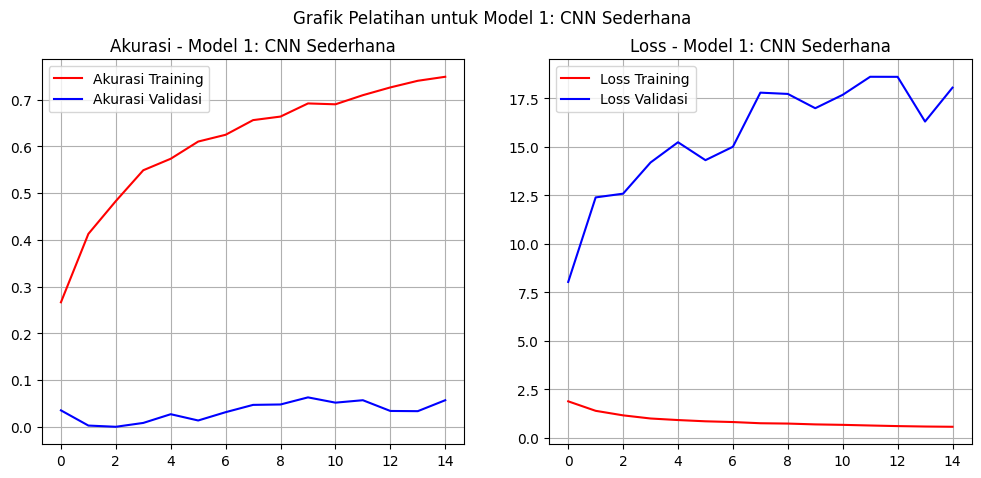

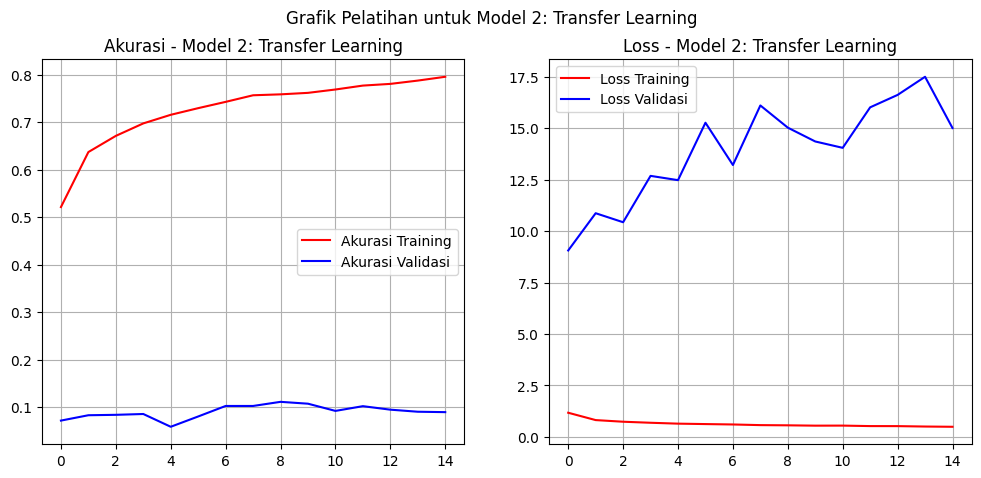

In [1]:

# --- 5. Visualisasi Hasil ---
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Akurasi Training')
    plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')
    plt.title(f'Akurasi - {title}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Loss Training')
    plt.plot(epochs, val_loss, 'b', label='Loss Validasi')
    plt.title(f'Loss - {title}')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Grafik Pelatihan untuk {title}")
    plt.show()

plot_history(history_1, "Model 1: CNN Sederhana")
plot_history(history_2, "Model 2: Transfer Learning")